# Gold Recovery Project

> The company *Zyfra* develops solutions for the efficient operation of industrial plants. The company needs a machine-learning model to help optimize production to avoid launching enterprises with unprofitable characteristics. The company needs a machine learning model to predict the recovery rate of gold from gold ore.

- toc: true
- badges: true
- comments: true
- categories: [jupyter, pandas, numpy, mathplotlib, scikit-learn]
- image: images/gold_recovery.jpg

# Project Description

---

Optimize the work of a gold-mining company by predicting amount of gold extracted.

Train a model which can predict the amount of gold extracted from gold ore based on extraction and purification data.

The data is stored in three files:
* `gold_recovery_train.csv` — training dataset 
* `gold_recovery_test.csv` — test dataset
* `gold_recovery_full.csv` — source dataset

Data is indexed with the date and time of acquisition (`date` feature). Parameters that are next to each other in terms of time are often similar.
Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

The source dataset contains the training and test sets with all the features.

## Technological process

---

When the mined ore undergoes primary processing, a crushed mixture is obtained. It is sent for flotation (enrichment) and two-stage purification:

1. Flotation - A mixture of gold-bearing ore is fed into the flotation plant. After beneficiation, a rough concentrate and "tailings", i.e. product leftovers with a low concentration of valuable metals, are obtained. The stability of this process is affected by the inconsistent and non-optimal physical and chemical state of the flotation slurry (mixture of solid particles and liquid).

2. Purification - The crude concentrate undergoes two purifications. The output is the final concentrate and new tailings.

# Import Libraries

In [ ]:
# Import in libraries to use in project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

# Exploratory data analysis

## Load Data

In [ ]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df = pd.read_csv('/datasets/gold_recovery_full.csv')

In [ ]:
# Functions to get descriptions and info from dataframe

def get_information(df):
  """ Prints general info about the dataframe to get an idea of what it looks like"""
  print('Head: \n')
  display(df.head())
  print('*'*100, '\n') # Prints a break to seperate print data
  
  print('Info: \n')
  display(df.info())
  print('*'*100, '\n')

  print('Describe: \n')
  display(df.describe())
  print('*'*100, '\n')

  print('Columns with nulls: \n')
  display(get_null_df(df,4))
  print('*'*100, '\n')

  print('Shape: \n')
  display(df.shape)
  print('*'*100, '\n')

  print('Duplicated: \n')
  print('Number of duplicated rows: {}'.format(df.duplicated().sum()))

def get_null_df(df, num):
  """Gets percentage of null values per column per dataframe"""
  df_nulls = pd.DataFrame(df.isna().sum(), columns=['missing_values'])
  df_nulls['percent_of_nulls'] = round(df_nulls['missing_values'] / df.shape[0], num) *100
  return df_nulls

def get_null(df):
  """Gets percentage of null values in dataframe"""
  count = 0
  df = df.copy()
  s = (df.isna().sum() / df.shape[0])
  for column, percent in zip(s.index, s.values):

    num_of_nulls = df[column].isna().sum()
    if num_of_nulls == 0:
      continue
    else:
      count += 1
    print('Columns {} has {:.{}%} percent of Nulls, and {} number of nulls'.format(column, percent, num, num_of_nulls))

    if count !=0:
      print('Number of columns with NA: {}'.format(count))
    else:
      print('\nNo NA columns found')

In [ ]:
get_information(df)

Head: 



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


**************************************************************************************************** 

Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cle

None

**************************************************************************************************** 

Describe: 



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


**************************************************************************************************** 

Columns with nulls: 



,missing_values,percent_of_nulls
date,0,0.00
final.output.concentrate_ag,89,0.39
final.output.concentrate_pb,87,0.38
final.output.concentrate_sol,385,1.69
final.output.concentrate_au,86,0.38
...,...,...
secondary_cleaner.state.floatbank5_a_level,101,0.44
secondary_cleaner.state.floatbank5_b_air,101,0.44
secondary_cleaner.state.floatbank5_b_level,100,0.44
secondary_cleaner.state.floatbank6_a_air,119,0.52


**************************************************************************************************** 

Shape: 



(22716, 87)

**************************************************************************************************** 

Duplicated: 

Number of duplicated rows: 0


In [ ]:
get_information(df_train)

Head: 



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


**************************************************************************************************** 

Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cle

None

**************************************************************************************************** 

Describe: 



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


**************************************************************************************************** 

Columns with nulls: 



,missing_values,percent_of_nulls
date,0,0.00
final.output.concentrate_ag,72,0.43
final.output.concentrate_pb,72,0.43
final.output.concentrate_sol,370,2.19
final.output.concentrate_au,71,0.42
...,...,...
secondary_cleaner.state.floatbank5_a_level,85,0.50
secondary_cleaner.state.floatbank5_b_air,85,0.50
secondary_cleaner.state.floatbank5_b_level,84,0.50
secondary_cleaner.state.floatbank6_a_air,103,0.61


**************************************************************************************************** 

Shape: 



(16860, 87)

**************************************************************************************************** 

Duplicated: 

Number of duplicated rows: 0


In [ ]:
get_information(df_test)

Head: 



,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


**************************************************************************************************** 

Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_

None

**************************************************************************************************** 

Describe: 



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


**************************************************************************************************** 

Columns with nulls: 



,missing_values,percent_of_nulls
date,0,0.00
primary_cleaner.input.sulfate,302,5.16
primary_cleaner.input.depressant,284,4.85
primary_cleaner.input.feed_size,0,0.00
primary_cleaner.input.xanthate,166,2.83
primary_cleaner.state.floatbank8_a_air,16,0.27
primary_cleaner.state.floatbank8_a_level,16,0.27
primary_cleaner.state.floatbank8_b_air,16,0.27
primary_cleaner.state.floatbank8_b_level,16,0.27
primary_cleaner.state.floatbank8_c_air,16,0.27


**************************************************************************************************** 

Shape: 



(5856, 53)

**************************************************************************************************** 

Duplicated: 

Number of duplicated rows: 0


df (soruce data) has 86 columns in total which is the same with the training dataset. Though df has 22716 entries while the training dataset has 16860 entries. The test dataset has 52 columns total and 5856 total entries. There are many missing values and null values that will not be easily replaced or can be filled in.

## Check that recovery is calculated correctly

Using the training set, calculate recovery for the `rougher.output.recovery` feature. Find the *MAE* between the calculated values and the feature values

In [ ]:
def rough_recovery(row):
  concentrate = row['rougher.output.concentrate_au']
  feed = row['rougher.input.feed_au']
  tail = row['rougher.output.tail_au']
  try:
    recovery = ((concentrate * (feed - tail)) / (feed * (concentrate - tail)))
    return recovery * 100
  except ZeroDivisionError:
    return 0

In [ ]:
au_calc_recovery = df_train.apply(rough_recovery, axis=1)
display(au_calc_recovery)

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64

In [ ]:
y_true, y_pred = df_train['rougher.output.recovery'], au_calc_recovery
au_recovery = pd.concat([y_true, y_pred], axis=1, sort=False)
au_recovery.columns = ['rougher.output.recovery', 'au_calc_recovery']
au_recovery.head(5)

,rougher.output.recovery,au_calc_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [ ]:
def calc_MAE(y_true, y_pred):
  try:
    return mean_absolute_error(y_true , y_pred)
  except ValueError:
    return 0

In [ ]:
au_recovery['MAE'] = calc_MAE(au_recovery['rougher.output.recovery'], au_recovery['au_calc_recovery'])
display(au_recovery.info())

display(au_recovery)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 3 columns):
rougher.output.recovery    14287 non-null float64
au_calc_recovery           14610 non-null float64
MAE                        16860 non-null int64
dtypes: float64(2), int64(1)
memory usage: 395.3 KB


None

,rougher.output.recovery,au_calc_recovery,MAE
0,87.107763,87.107763,0
1,86.843261,86.843261,0
2,86.842308,86.842308,0
3,87.226430,87.226430,0
4,86.688794,86.688794,0
...,...,...,...
16855,89.574376,89.574376,0
16856,87.724007,87.724007,0
16857,88.890579,88.890579,0
16858,89.858126,89.858126,0


Text(0.5, 1.0, 'Histogram for Variance of MAE calculation')

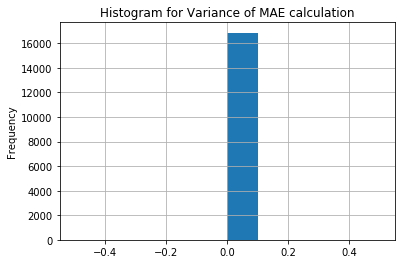

In [ ]:
au_recovery['MAE'].plot.hist(grid=True)
plt.title("Histogram for Variance of MAE calculation")

In [ ]:
print('Maximum value on au_recovery MAE calculation:', au_recovery['MAE'].max())
print('Minimum value on au_recovery MAE calculation:', au_recovery['MAE'].min())

Maximum value on au_recovery MAE calculation: 0
Minimum value on au_recovery MAE calculation: 0


There were missing values for both the calculated recovery and also for the `rougher.output.recovery` feature. 0 was replaced for those rows where a MAE calculation could not be made. It was discovered that 0 was the only outcome for MAE calculation between the two which indicates that there is no error between the calculated values and the actual values.

## Analyze the features not available in the test set

In [ ]:
# Finding the columns/parameters that are not in df_test
cols_not_test = set(df).difference(set(df_test))

print('Number of columns missing from test dataset:', len(cols_not_test))
display(cols_not_test)

Number of columns missing from test dataset: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

There are 34 columns missing from the test dataset and all the dtype for these columns is float which are output values or calculations. It's good to note that the test dataset is missing the two target columns (`final.output.recovery` and `rougher.output.recovery`).

## Preprocessing Data

We can use our formula to calculate the `rougher.output.recovery` since earlier we've determined that the MAE shows 0 bewteen the calculation values and the actual values. This will help fill in the missing gaps in `rougher.output.recovery` column.

In [ ]:
df['rougher.output.recovery'] = df.apply(rough_recovery, axis=1)
df_train['rougher.output.recovery'] = df_train.apply(rough_recovery, axis=1)

It might be a good idea to fill missing values and null values in the datasets with fillna(method=‘ffill’) since the data ordered by time.

In [ ]:
df.fillna(method='ffill', inplace=True)
display(df.info())

df_test.fillna(method='ffill', inplace=True)
display(df_test.info())

df_train.fillna(method='ffill', inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22716 non-null float64
final.output.concentrate_pb                           22716 non-null float64
final.output.concentrate_sol                          22716 non-null float64
final.output.concentrate_au                           22716 non-null float64
final.output.recovery                                 22716 non-null float64
final.output.tail_ag                                  22716 non-null float64
final.output.tail_pb                                  22716 non-null float64
final.output.tail_sol                                 22716 non-null float64
final.output.tail_au                                  22716 non-null float64
primary_cleaner.input.sulfate                         22716 non-null float64
primary_cleaner.input.depressant             

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
rougher.in

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16860 non-null float64
final.output.concentrate_pb                           16860 non-null float64
final.output.concentrate_sol                          16860 non-null float64
final.output.concentrate_au                           16860 non-null float64
final.output.recovery                                 16860 non-null float64
final.output.tail_ag                                  16860 non-null float64
final.output.tail_pb                                  16860 non-null float64
final.output.tail_sol                                 16860 non-null float64
final.output.tail_au                                  16860 non-null float64
primary_cleaner.input.sulfate                         16860 non-null float64
primary_cleaner.input.depressant             

We were able to fill in some missing values with our calculation of the `rougher.output.recover` for both training and test datasets as well as fill in the rest of the missing and null values using the fillna(method=‘ffill’) since the data ordered by time (it fills in null values with the previous data from the instance).

## Visualize


### Concentrations of metals (Au, Ag, Pb) at each different  purification stage

(0, 55)

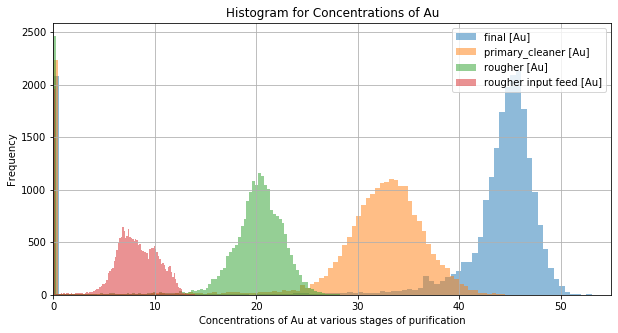

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df['final.output.concentrate_au'], bins=100, alpha=0.5, label='final [Au]')
plt.hist(df['primary_cleaner.output.concentrate_au'], bins=100, alpha=0.5, label='primary_cleaner [Au]')
plt.hist(df['rougher.output.concentrate_au'], bins=100, alpha=0.5, label='rougher [Au]')
plt.hist(df['rougher.input.feed_au'], bins=100, alpha=0.5, label='rougher input feed [Au]')
plt.xlabel('Concentrations of Au at various stages of purification')
plt.ylabel('Frequency')
plt.title("Histogram for Concentrations of Au")
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(0, 55)

Au (gold) concentrations get more concentrated with each stage of purification which is to be expected as the impurities are removed with each stage and the target being gold recovery that concentrations of Au would be greatest at the final stage.

(0, 22)

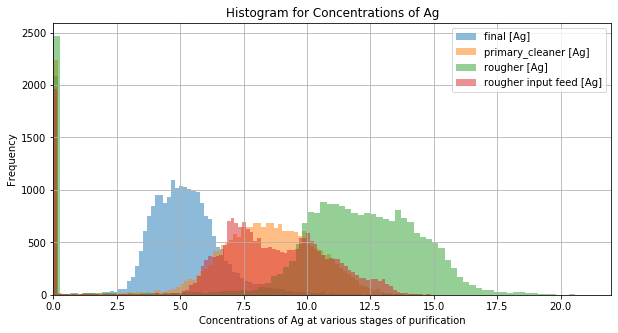

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df['final.output.concentrate_ag'], bins=100, alpha=0.5, label='final [Ag]')
plt.hist(df['primary_cleaner.output.concentrate_ag'], bins=100, alpha=0.5, label='primary_cleaner [Ag]')
plt.hist(df['rougher.output.concentrate_ag'], bins=100, alpha=0.5, label='rougher [Ag]')
plt.hist(df['rougher.input.feed_ag'], bins=100, alpha=0.5, label='rougher input feed [Ag]')

plt.xlabel('Concentrations of Ag at various stages of purification')
plt.ylabel('Frequency')
plt.title("Histogram for Concentrations of Ag")
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(0, 22)

Concentrations for Ag (silver) decrease with each stage of purification which is to be expected as Ag is considered a impurity in the target gold recovery.

(0, 17)

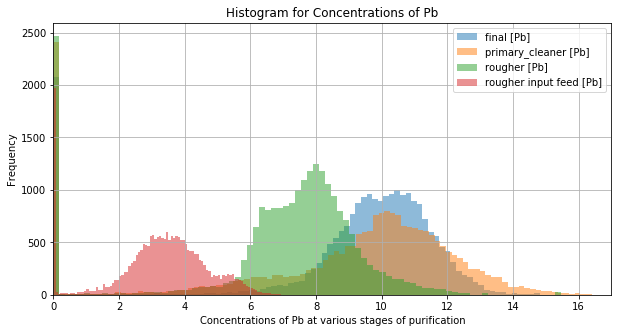

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df['final.output.concentrate_pb'], bins=100, alpha=0.5, label='final [Pb]')
plt.hist(df['primary_cleaner.output.concentrate_pb'], bins=100, alpha=0.5, label='primary_cleaner [Pb]')
plt.hist(df['rougher.output.concentrate_pb'], bins=100, alpha=0.5, label='rougher [Pb]')
plt.hist(df['rougher.input.feed_pb'], bins=100, alpha=0.5, label='rougher input feed [Pb]')

plt.xlabel('Concentrations of Pb at various stages of purification')
plt.ylabel('Frequency')
plt.title("Histogram for Concentrations of Pb")
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(0, 17)

Interesting with Pb concentrations (lead) seems to have slightly increase with each stage of purification. This might be due to how the process of gold recovery is done where the solute might be not be able to filter out lead as easily as other impurities. Though the concentration really is not nearly as concentrated in comparison to gold.

There appears to be outliers where concentraions of metals are 0. 

### Compare the feed particle size distributions in the training set and in the test set

If the distributions vary significantly, the model evaluation will be incorrect.

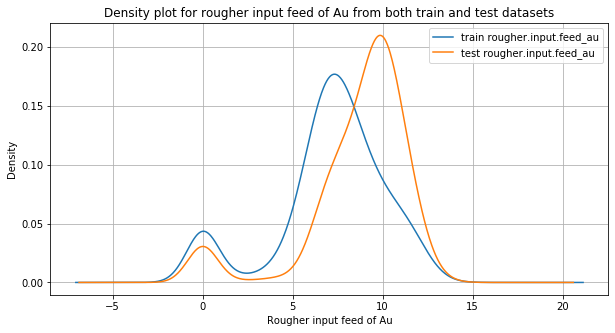

In [ ]:
plt.figure(figsize=(10,5))
df_train['rougher.input.feed_au'].plot.kde(bw_method=0.3)
df_test['rougher.input.feed_au'].plot.kde(bw_method=0.3)


plt.xlabel('Rougher input feed of Au')
plt.ylabel('Density')
plt.title("Density plot for rougher input feed of Au from both train and test datasets")
plt.legend(['train rougher.input.feed_au', 'test rougher.input.feed_au'],loc='upper right')
plt.grid(True)

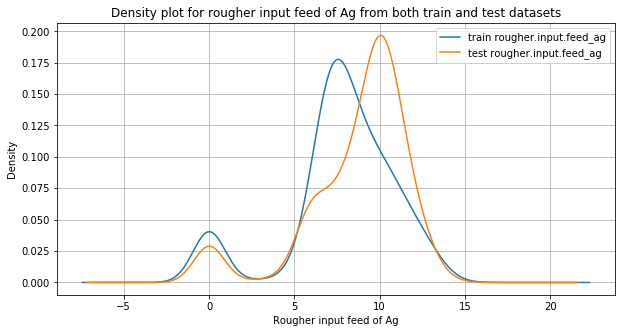

In [ ]:
plt.figure(figsize=(10,5))
df_train['rougher.input.feed_ag'].plot.kde(bw_method=0.3)
df_test['rougher.input.feed_ag'].plot.kde(bw_method=0.3)


plt.xlabel('Rougher input feed of Ag')
plt.ylabel('Density')
plt.title("Density plot for rougher input feed of Ag from both train and test datasets")
plt.legend(['train rougher.input.feed_ag', 'test rougher.input.feed_ag'],loc='upper right')
plt.grid(True)

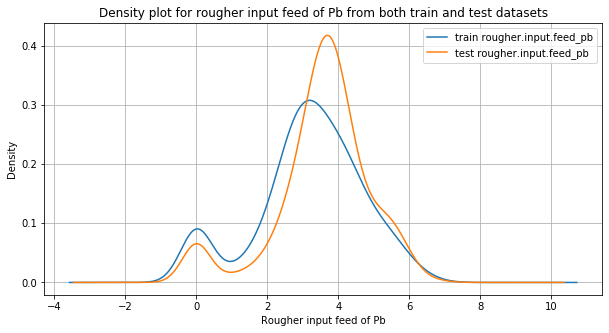

In [ ]:
plt.figure(figsize=(10,5))
df_train['rougher.input.feed_pb'].plot.kde(bw_method=0.3)
df_test['rougher.input.feed_pb'].plot.kde(bw_method=0.3)


plt.xlabel('Rougher input feed of Pb')
plt.ylabel('Density')
plt.title("Density plot for rougher input feed of Pb from both train and test datasets")
plt.legend(['train rougher.input.feed_pb', 'test rougher.input.feed_pb'],loc='upper right')
plt.grid(True)

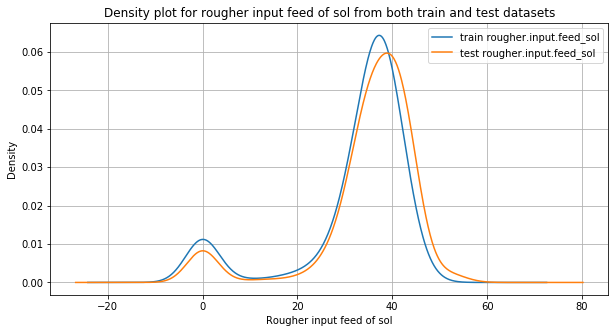

In [ ]:
plt.figure(figsize=(10,5))
df_train['rougher.input.feed_sol'].plot.kde(bw_method=0.3)
df_test['rougher.input.feed_sol'].plot.kde(bw_method=0.3)


plt.xlabel('Rougher input feed of sol')
plt.ylabel('Density')
plt.title("Density plot for rougher input feed of sol from both train and test datasets")
plt.legend(['train rougher.input.feed_sol', 'test rougher.input.feed_sol'],loc='upper right')
plt.grid(True)

(-10, 175)

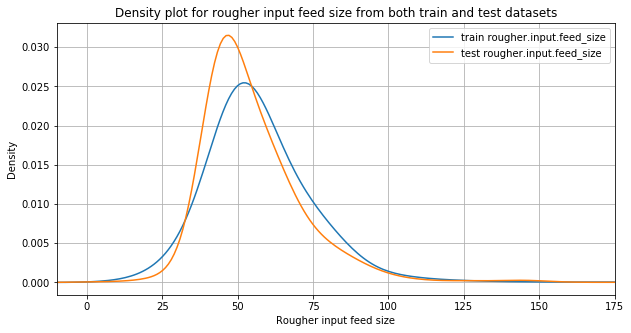

In [ ]:
plt.figure(figsize=(10,5))
df_train['rougher.input.feed_size'].plot.kde(bw_method=0.3)
df_test['rougher.input.feed_size'].plot.kde(bw_method=0.3)


plt.xlabel('Rougher input feed size')
plt.ylabel('Density')
plt.title("Density plot for rougher input feed size from both train and test datasets")
plt.legend(['train rougher.input.feed_size', 'test rougher.input.feed_size'],loc='upper right')
plt.grid(True)
plt.xlim(-10, 175)

From the plots we can see that the particle size feed for each Au, Ag, Pb, sol, and feed size from train and test datasets are fairly similar. 

### Total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate

In [ ]:
# Functions to calculate totals

def total_rough_feed(df):
  au = df['rougher.input.feed_au']
  ag = df['rougher.input.feed_ag']
  pb = df['rougher.input.feed_pb']
  sol = df['rougher.input.feed_sol']

  total = au + ag + pb + sol

  return total

def total_rough_conc(df):
  au = df['rougher.output.concentrate_au']
  ag = df['rougher.output.concentrate_ag']
  pb = df['rougher.output.concentrate_pb']
  sol = df['rougher.output.concentrate_sol']

  total = au + ag + pb + sol

  return total

def total_final_conc(df):
  au = df['final.output.concentrate_au']
  ag = df['final.output.concentrate_ag']
  pb = df['final.output.concentrate_pb']
  sol = df['final.output.concentrate_sol']

  total = au + ag + pb + sol

  return total

In [ ]:
df['total_rough_feed'] = total_rough_feed(df)
df['total_rough_conc'] = total_rough_conc(df)
df['total_final_conc'] = total_final_conc(df)

df[['date','total_rough_feed','total_rough_conc', 'total_final_conc']]

,date,total_rough_feed,total_rough_conc,total_final_conc
0,2016-01-15 00:00:00,51.680034,66.424950,63.644396
1,2016-01-15 01:00:00,50.659114,67.012710,63.957723
2,2016-01-15 02:00:00,50.609929,66.103793,64.311180
3,2016-01-15 03:00:00,51.061546,65.752751,63.573449
4,2016-01-15 04:00:00,47.859163,65.908382,64.004667
...,...,...,...,...
22711,2018-08-18 06:59:59,53.415050,70.781325,68.098589
22712,2018-08-18 07:59:59,53.696482,70.539603,68.274362
22713,2018-08-18 08:59:59,54.589604,55.376330,68.226068
22714,2018-08-18 09:59:59,54.027355,69.201689,68.200449


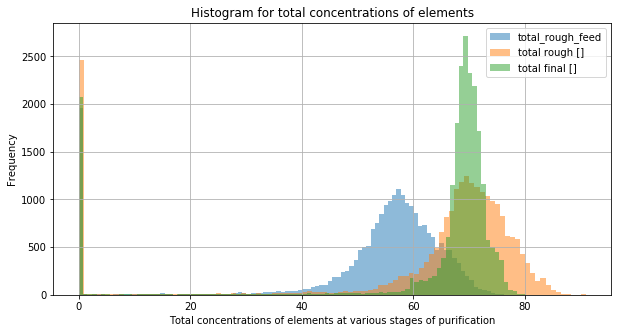

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df['total_rough_feed'], bins=100, alpha=0.5, label='total_rough_feed')
plt.hist(df['total_rough_conc'], bins=100, alpha=0.5, label='total rough []')
plt.hist(df['total_final_conc'], bins=100, alpha=0.5, label='total final []')

plt.xlabel('Total concentrations of elements at various stages of purification')
plt.ylabel('Frequency')
plt.title("Histogram for total concentrations of elements")
plt.legend(loc='upper right')
plt.grid(True)

From the histogram of total concentrations of all elements the obvious abnormal values are the ones that linger around 0. It's best to drop these values moving forward. It is ideal to remove these values from both test and train datasets because if we only remove from train, the model will be shocked with such examples on test in comparison.

In [ ]:
# Remove values around 0 from 'total_rough_feed', 'total_rough_conc', 'total_final_conc' columns
df = df[df['total_rough_feed'] > 1] 
df = df[df['total_rough_conc'] > 1] 
df = df[df['total_final_conc'] > 1] 

In [ ]:
# Merging columns 'total_rough_feed', 'total_rough_conc', 'total_final_conc' from df to aid in removing abnormal values
df_train_clean = pd.merge(df_train, df[['date', 'total_rough_feed', 'total_rough_conc', 'total_final_conc']],on='date', how='left')

# Removing 0 values from 'total_rough_feed', 'total_rough_conc', 'total_final_conc' columns
columns = ['total_rough_feed', 'total_rough_conc', 'total_final_conc']
df_train_clean = df_train_clean.replace(0, np.nan).dropna(axis=0, how='any', subset=columns).fillna(0)

df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14612 entries, 0 to 16859
Data columns (total 90 columns):
date                                                  14612 non-null object
final.output.concentrate_ag                           14612 non-null float64
final.output.concentrate_pb                           14612 non-null float64
final.output.concentrate_sol                          14612 non-null float64
final.output.concentrate_au                           14612 non-null float64
final.output.recovery                                 14612 non-null float64
final.output.tail_ag                                  14612 non-null float64
final.output.tail_pb                                  14612 non-null float64
final.output.tail_sol                                 14612 non-null float64
final.output.tail_au                                  14612 non-null float64
primary_cleaner.input.sulfate                         14612 non-null float64
primary_cleaner.input.depressant             

In [ ]:
# Merging columns 'total_rough_feed', 'total_rough_conc', 'total_final_conc' from df to aid in removing abnormal values
df_test_clean = pd.merge(df_test, df[['date', 'total_rough_feed', 'total_rough_conc', 'total_final_conc']],on='date', how='left')

# Removing 0 values from 'total_rough_feed', 'total_rough_conc', 'total_final_conc' columns
columns = ['total_rough_feed', 'total_rough_conc', 'total_final_conc']
df_test_clean = df_test_clean.replace(0, np.nan).dropna(axis=0, how='any', subset=columns).fillna(0)

df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5855
Data columns (total 56 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [ ]:
# Removing 0 values from 'total_rough_feed', 'total_rough_conc', 'total_final_conc' columns
columns = ['total_rough_feed', 'total_rough_conc', 'total_final_conc']
df_clean = df.replace(0, np.nan).dropna(axis=0, how='any', subset=columns).fillna(0)

display(df.info())
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19902 entries, 0 to 22715
Data columns (total 90 columns):
date                                                  19902 non-null object
final.output.concentrate_ag                           19902 non-null float64
final.output.concentrate_pb                           19902 non-null float64
final.output.concentrate_sol                          19902 non-null float64
final.output.concentrate_au                           19902 non-null float64
final.output.recovery                                 19902 non-null float64
final.output.tail_ag                                  19902 non-null float64
final.output.tail_pb                                  19902 non-null float64
final.output.tail_sol                                 19902 non-null float64
final.output.tail_au                                  19902 non-null float64
primary_cleaner.input.sulfate                         19902 non-null float64
primary_cleaner.input.depressant             

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19902 entries, 0 to 22715
Data columns (total 90 columns):
date                                                  19902 non-null object
final.output.concentrate_ag                           19902 non-null float64
final.output.concentrate_pb                           19902 non-null float64
final.output.concentrate_sol                          19902 non-null float64
final.output.concentrate_au                           19902 non-null float64
final.output.recovery                                 19902 non-null float64
final.output.tail_ag                                  19902 non-null float64
final.output.tail_pb                                  19902 non-null float64
final.output.tail_sol                                 19902 non-null float64
final.output.tail_au                                  19902 non-null float64
primary_cleaner.input.sulfate                         19902 non-null float64
primary_cleaner.input.depressant             

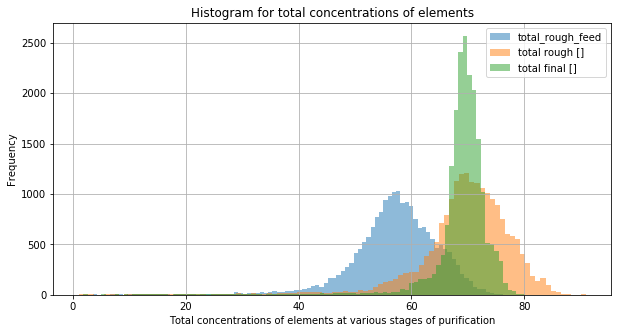

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_clean['total_rough_feed'], bins=100, alpha=0.5, label='total_rough_feed')
plt.hist(df_clean['total_rough_conc'], bins=100, alpha=0.5, label='total rough []')
plt.hist(df_clean['total_final_conc'], bins=100, alpha=0.5, label='total final []')

plt.xlabel('Total concentrations of elements at various stages of purification')
plt.ylabel('Frequency')
plt.title("Histogram for total concentrations of elements")
plt.legend(loc='upper right')
plt.grid(True)

We were able to successfully drop most of abnormal values from our distrubtion from the full dataset, train dataset, and test dataset.

# Model Building

## Evaluation Metrics

Write a function to calculate the final *sMAPE* value

In [ ]:
# Symmetric Mean Absolute Percentage Error

def calc_smape(target, prediction):
    try:
        smape = 100/len(target) * np.abs(np.sum(2 * np.abs(prediction - target) / (np.abs(target) + np.abs(prediction))))
        return smape
    except ZeroDivisionError:
        return 0

def calc_f_smape(target, prediction):
    r_smape = calc_smape(target[0], prediction[0])
    f_smape = calc_smape(target[1], prediction[1])
    
    final_smape = (0.25 * r_smape) + (0.75 * f_smape)
    
    return final_smape

In [ ]:
smape_scorer = make_scorer(calc_f_smape, greater_is_better=False)
smape_scorer

make_scorer(calc_f_smape, greater_is_better=False)

Parameter `greater_is_better=False` is used so further algorithms could understand that we want to minimize the score.


## Prepare data subsets

In [ ]:
# Dropping columns missing in original test dataset from train dataset and any other unnecessary columns

df_train_complete = df_train_clean.drop(['final.output.concentrate_ag',
                                  'final.output.concentrate_au',
                                  'final.output.concentrate_pb',
                                  'final.output.concentrate_sol',
                                  'final.output.tail_ag',
                                  'final.output.tail_au',
                                  'final.output.tail_pb',
                                  'final.output.tail_sol',
                                  'primary_cleaner.output.concentrate_ag',
                                  'primary_cleaner.output.concentrate_au',
                                  'primary_cleaner.output.concentrate_pb',
                                  'primary_cleaner.output.concentrate_sol',
                                  'primary_cleaner.output.tail_ag',
                                  'primary_cleaner.output.tail_au',
                                  'primary_cleaner.output.tail_pb',
                                  'primary_cleaner.output.tail_sol',
                                  'rougher.calculation.au_pb_ratio',
                                  'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                  'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                  'rougher.calculation.sulfate_to_au_concentrate',
                                  'rougher.output.concentrate_ag',
                                  'rougher.output.concentrate_au',
                                  'rougher.output.concentrate_pb',
                                  'rougher.output.concentrate_sol',
                                  'rougher.output.tail_ag',
                                  'rougher.output.tail_au',
                                  'rougher.output.tail_pb',
                                  'rougher.output.tail_sol',
                                  'secondary_cleaner.output.tail_ag',
                                  'secondary_cleaner.output.tail_au',
                                  'secondary_cleaner.output.tail_pb',
                                  'secondary_cleaner.output.tail_sol',
                                  'total_rough_feed', 
                                  'total_rough_conc', 'total_final_conc', 'date'], axis=1)
df_train_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14612 entries, 0 to 16859
Data columns (total 54 columns):
final.output.recovery                         14612 non-null float64
primary_cleaner.input.sulfate                 14612 non-null float64
primary_cleaner.input.depressant              14612 non-null float64
primary_cleaner.input.feed_size               14612 non-null float64
primary_cleaner.input.xanthate                14612 non-null float64
primary_cleaner.state.floatbank8_a_air        14612 non-null float64
primary_cleaner.state.floatbank8_a_level      14612 non-null float64
primary_cleaner.state.floatbank8_b_air        14612 non-null float64
primary_cleaner.state.floatbank8_b_level      14612 non-null float64
primary_cleaner.state.floatbank8_c_air        14612 non-null float64
primary_cleaner.state.floatbank8_c_level      14612 non-null float64
primary_cleaner.state.floatbank8_d_air        14612 non-null float64
primary_cleaner.state.floatbank8_d_level      14612 non-null fl

We removed the columns that were not present in the test dataset from training. These additional columns can confuse the model if they are useless (since they were not present in the original test dataset). If several features were added with random values to any model it will likely reduce the quality. That’s why it’s important to use only proper features. This is why we are prepping the train dataset for the model training.

In [ ]:
# Getting columns final.output.recovery and rougher.output.recovery for test dataset and removing 'total_rough_feed', 'total_rough_conc', 'total_final_conc' columns

df_test_complete = pd.merge(df_test_clean, df[['date', 'final.output.recovery', 'rougher.output.recovery']],on='date', how='left')
df_test_complete = df_test_complete.drop(['total_rough_feed', 'total_rough_conc', 'total_final_conc', 'date'], axis=1)
df_test_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                         5290 non-null float64
rougher.i

We added in the missing target columns to the test dataset from the original df.

In [ ]:
# Get features/target for train sub dataset
x_train = df_train_complete.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train = df_train_complete[['rougher.output.recovery', 'final.output.recovery']]

# Get features/target for test sub dataset
x_test = df_test_complete.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_test = df_test_complete[['rougher.output.recovery', 'final.output.recovery']]

## Train different models

Evaluate them using cross-validation. Pick the best model and test it using the test sample.

In [ ]:
def get_cv_scores(classifier, x_train, y_train):

    kfold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

    cross_val_smape = np.abs(cross_val_score(classifier, x_train, y_train.to_numpy(), scoring=smape_scorer, cv=kfold))

    print('Mean Cross-Validation sMAPE Score:', cross_val_smape.mean())
    print('Min Cross-Validation sMAPE Score:', cross_val_smape.min())
    print('Max Cross-Validation sMAPE Score:', cross_val_smape.max())

### LinearRegression

In [ ]:
lr = MultiOutputRegressor(LinearRegression())

print('Linear Regression model:')
get_cv_scores(lr, x_train, y_train)

Linear Regression model:
Mean Cross-Validation sMAPE Score: 34.341736599192494
Min Cross-Validation sMAPE Score: 7.541454024526066
Max Cross-Validation sMAPE Score: 47.99015041175999


### DecisionTree

In [ ]:
dt = MultiOutputRegressor(DecisionTreeRegressor(random_state=RANDOM_STATE))

print('Decision Tree model:')
get_cv_scores(dt, x_train, y_train)

Decision Tree model:
Mean Cross-Validation sMAPE Score: 2.1941193666185566
Min Cross-Validation sMAPE Score: 0.6229571145328955
Max Cross-Validation sMAPE Score: 3.9114996607788086


### RandomForest

In [ ]:
rf = MultiOutputRegressor(RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100))

print('Random Forest model:')
get_cv_scores(rf, x_train, y_train)

Random Forest model:
Mean Cross-Validation sMAPE Score: 2.3734912002748216
Min Cross-Validation sMAPE Score: 1.2144453600511473
Max Cross-Validation sMAPE Score: 4.28980393715649


### Conclusion

| Cross-Validation of 5 fold sMAPE Scores | Mean | Min | Max |
|:---|:---|:---|:---|
| Linear Regression | 34.34 | 7.54 | 47.99 | 
| Decision Tree | 2.19 | 0.623 | 3.91 |
| Random Forest | 2.37 | 1.21 | 4.29 |

Looking that the sMAPE scores from the cross-validation of 5 fold, Decision Tree Regression model has the best lowest sMAPE scores across the mean, min, and max.

## Parameter tuning

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'estimator__max_depth': range(1, 15),
    'estimator__min_samples_leaf': range(1, 15)
}

# Create a based model
model = MultiOutputRegressor(DecisionTreeRegressor(random_state=RANDOM_STATE))

# Instantiate the grid search model
grid_search = GridSearchCV(estimator= model, param_grid= param_grid, 
                           scoring= smape_scorer, cv= 3, n_jobs= -1, verbose= 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train.to_numpy())
best_param = grid_search.best_params_


print("\n The best score across ALL searched params:\n",
          grid_search.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid_search.best_params_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
[CV] estimator__max_depth=1, estimator__min_samples_leaf=1 ...........
[CV]  estimator__max_depth=1, estimator__min_samples_leaf=1, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_samples_leaf=1 ...........


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  estimator__max_depth=1, estimator__min_samples_leaf=1, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_samples_leaf=1 ...........
[CV]  estimator__max_depth=1, estimator__min_samples_leaf=1, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_samples_leaf=2 ...........
[CV]  estimator__max_depth=1, estimator__min_samples_leaf=2, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_samples_leaf=2 ...........
[CV]  estimator__max_depth=1, estimator__min_samples_leaf=2, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_samples_leaf=2 ...........
[CV]  estimator__max_depth=1, estimator__min_samples_leaf=2, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_samples_leaf=3 ...........
[CV]  estimator__max_depth=1, estimator__min_samples_leaf=3, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_samples_leaf=3 ...........
[CV]  estimator__max_depth=1, estimator__min_samples_leaf=3, total=   0.1s
[CV] estimator__max_depth=1, estimator__min_sampl

[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:  6.2min finished



 The best score across ALL searched params:
 -2.457959649299341

 The best parameters across ALL searched params:
 {'estimator__max_depth': 2, 'estimator__min_samples_leaf': 13}


## Model Selection

In [ ]:
model = MultiOutputRegressor(DecisionTreeRegressor(random_state=RANDOM_STATE, 
                                                   max_depth=2, min_samples_leaf=13))

model.fit(x_train, y_train.to_numpy())

prediction = model.predict(x_test)

In [ ]:
smape = calc_smape(y_test.to_numpy(), prediction)
print('Final sMAPE score: ', smape)

Final sMAPE score:  14.464377261082916


# Overall Conclusion

To fill the null values in the original datasets, we used `fillna(method='ffill')` since the data is ordered by time. MAE calculation values were also used to replace the original values in the datasets. We dropped the abnormal values for concentrations that were equal to and/or close to 0. And then we trained Linear Regression, Decision Tree Regressor, and Random Forest Regressor using the train dataset with a cross-validation of 5 fold to obtain sMAPE scores. Decision Tree had the best lowest sMAPE scores overall and was selected undergo hyper parameterization with `GridSearchCV`. Below sums up the final Decision Tree model and it's parameters:

| Decision Tree Regression | |
|:---|:---|
| *Parameters:* | *random_state= 42, max_depth=2, min_samples_leaf=13* | 
| Final sMAPE score | 14.4644 |

Testing the final model using the test dataset gave us the final sMAPE score of 14.46% which is higher than our cross-validation mean score which used the only used train dataset. 

